# Support Vector Machine (SVM) para Análisis de Sentimientos
En el jupyter notebook se puede ver la construcción de un modelo SVM que predice el sentimiento de un comentario de redes sociales para dos productos ecuatorianos. Incluye la limpieza de datos, su preprocesamiento, preparación, construcción del modelo y evaluación del modelo.

**Código desarrollado por: Camila Revelo, Joel Marín y Jordy Urquizo**

### Importación de librerías para usar  
En esta celda se importan las librerías que se utilizarán durante el proyecto. Algunas de ellas viene incluidas con Anaconda, pero otras deben ser descargadas si no se lo ha hecho. 

In [2]:
#Se importan las librerías necesarias
from sklearn import metrics
import numpy as np # álgebra lineal 
import pandas as pd # procesamiento de datos
import re, string, nltk
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup

### Comprensión y limpieza de los datos 
En esta fase se llevó a cabo la extracción y recopilación de los comentarios de los usuarios sobre dos productos específicos. Estos comentarios se derivaron de varias publicaciones en redes sociales como Facebook e Instagram.

In [3]:
#Se importa el set de datos de entrenamiento 
data = pd.read_excel("Yelp.xlsx")

#print head
data.head()

,content,Polarity_Rating
0,Guau ... Me encantó este lugar.,Positive
1,La corteza no es buena.,Negative
2,No es sabroso y la textura era simplemente des...,Negative
3,Pasé por allí durante el feriado bancario de f...,Positive
4,"La selección del menú era excelente, al igual ...",Positive


In [4]:
#Se limpian los comentarios para posteriormente preprocesarlos
data_clean = data.copy()
data_clean['content_clean'] = data_clean['content'].apply(lambda x: BeautifulSoup(x, "lxml").text) # Se modifica el nombre de la columna content (sobre los comentarios)
data_clean = data_clean.loc[:, ['content_clean', 'Polarity_Rating']] # Se localizan las dos columnas de interes
data_clean.head()

C:\Users\gpulg\anaconda3\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "Con: servicio irregular. " looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


,content_clean,Polarity_Rating
0,Guau ... Me encantó este lugar.,Positive
1,La corteza no es buena.,Negative
2,No es sabroso y la textura era simplemente des...,Negative
3,Pasé por allí durante el feriado bancario de f...,Positive
4,"La selección del menú era excelente, al igual ...",Positive


### Preprocesamiento de los datos 
A pesar de que los métodos de extracción utilizados para obtener comentarios de los usuarios en las redes sociales dan una tabla que incluye los comentarios en una columna (content), los datos de texto presentes allí no se pueden alimentar a un modelo de machine learning tal como está. Por lo tanto, se deben seguir algunos pasos de preprocesamiento para garantizar que la entrada al modelo desarrollado sea la óptima y que se generen menos características.

In [5]:
data_clean['content_clean'] = data_clean['content_clean'].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #elimina url

In [6]:
data_clean['content_clean'] = data_clean['content_clean'].apply(lambda x: re.split('\d+', str(x))[0]) #elimina palabras con numeros

In [7]:
#Elimina palabras con letras repetidas
def conti_rep_char(str1):
    tchr = str1.group(0)
    if len(tchr) > 1:
      return tchr[0:1]
      
def check_unique_char(rep, sent_text):
    
    convert = re.sub(r'(\w)\1+', 
                     rep,
                     sent_text)
      
    # retorna la palabra convertida
    return convert
  
data_clean['content_clean'] = data_clean['content_clean'].apply(
                                   lambda x : check_unique_char(conti_rep_char,
                                                              x))
# mostrar Dataframe
data_clean

,content_clean,Polarity_Rating
0,Guau ... Me encantó este lugar.,Positive
1,La corteza no es buena.,Negative
2,No es sabroso y la textura era simplemente des...,Negative
3,Pasé por alí durante el feriado bancario de fi...,Positive
4,"La seleción del menú era excelente, al igual q...",Positive
...,...,...
995,Creo que la comida debería tener sabor y textu...,Negative
996,El apetito desapareció instantáneamente.,Negative
997,"En general, no me impresionó y no volvería.",Negative
998,"Toda la experiencia fue decepcionante, y creo ...",Negative


In [8]:
# Para instalar paquete de emojis preestablecidos
!pip install emoji

In [9]:
# Se importa libreria emoji
import emoji

def get_mentions_processing(text):
    return " ".join(filter(lambda x:x[0]!='@', text.split())) #no menciones

def get_hashtags_processing(text):
    return " ".join(filter(lambda x:x[0]!='#', text.split())) #no hashtags

def get_emojis_processing(text):
    return str(emoji.demojize(text,language='es')).replace(":"," ") #emojis a texto

def get_less3words_processing(text):
    return ' '.join([word for word in text.split() if len(word)>2]) #palabras con menos de 3 caracteres

def get_text_processing(text):
    stpword = stopwords.words('spanish')
    no_punctuation = [char for char in text if char not in string.punctuation] #elimina puntuacion
    no_punctuation = ''.join(no_punctuation).lower() #convierte en minuscula
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword]) #elimina stopwords

In [10]:
# Se importan y se descargan stopwords preestablecidos
from nltk.corpus import stopwords
nltk.download('stopwords')
data_clean = data_clean.sample(frac=1).reset_index(drop=True)
df1 = pd.DataFrame()
df1 = data_clean
df1['content_clean'] = data_clean['content_clean']
df1['Content_Review'] = data_clean['content_clean'].apply(get_mentions_processing)
df1['Content_Review1'] = df1['Content_Review'].apply(get_hashtags_processing)
df1['Content_Review2'] = df1['Content_Review1'].apply(get_emojis_processing)
df1['Content_Review3'] = df1['Content_Review2'].apply(get_text_processing)
df1['Content_Review4'] = df1['Content_Review3'].apply(get_less3words_processing) #En un dataframe, se remueven los stopwords y obtienen los comentarios limpios con los que se va a trabajar
df1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gpulg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,content_clean,Polarity_Rating,Content_Review,Content_Review1,Content_Review2,Content_Review3,Content_Review4
0,El nivel,Positive,El nivel,El nivel,El nivel,nivel,nivel
1,No sé cómo se las aregló este lugar para servi...,Negative,No sé cómo se las aregló este lugar para servi...,No sé cómo se las aregló este lugar para servi...,No sé cómo se las aregló este lugar para servi...,sé cómo aregló lugar servir comida blanda comi...,cómo aregló lugar servir comida blanda comido ...
2,"Asegúrese de pedir postre, incluso si necesita...",Positive,"Asegúrese de pedir postre, incluso si necesita...","Asegúrese de pedir postre, incluso si necesita...","Asegúrese de pedir postre, incluso si necesita...",asegúrese pedir postre incluso si necesita emp...,asegúrese pedir postre incluso necesita empaca...
3,"Después de un bocado, me enganché.",Positive,"Después de un bocado, me enganché.","Después de un bocado, me enganché.","Después de un bocado, me enganché.",después bocado enganché,después bocado enganché
4,Es PERFECTO para una comida familiar sentada o...,Positive,Es PERFECTO para una comida familiar sentada o...,Es PERFECTO para una comida familiar sentada o...,Es PERFECTO para una comida familiar sentada o...,perfecto comida familiar sentada reunirse amigos,perfecto comida familiar sentada reunirse amigos
...,...,...,...,...,...,...,...
995,Mi marido y yo comimos aquí y quedamos muy dec...,Negative,Mi marido y yo comimos aquí y quedamos muy dec...,Mi marido y yo comimos aquí y quedamos muy dec...,Mi marido y yo comimos aquí y quedamos muy dec...,marido comimos aquí quedamos decepcionados com...,marido comimos aquí quedamos decepcionados com...
996,Es difícil juzgar si estos lados eran buenos p...,Negative,Es difícil juzgar si estos lados eran buenos p...,Es difícil juzgar si estos lados eran buenos p...,Es difícil juzgar si estos lados eran buenos p...,difícil juzgar si lados buenos asqueados espum...,difícil juzgar lados buenos asqueados espuma p...
997,"Muy, muy decepcionado ordenó el plato de $",Negative,"Muy, muy decepcionado ordenó el plato de $","Muy, muy decepcionado ordenó el plato de $","Muy, muy decepcionado ordenó el plato de $",decepcionado ordenó plato,decepcionado ordenó plato
998,Estoy super cabreado.,Negative,Estoy super cabreado.,Estoy super cabreado.,Estoy super cabreado.,super cabreado,super cabreado


In [11]:
# Se crea un dataframe con unicamente el comentario y su polaridad en cuanto al sentimiento
df2 = pd.DataFrame()
df2 = df1
df2 = df1[['Content_Review4', 'Polarity_Rating']]
df2.head()

,Content_Review4,Polarity_Rating
0,nivel,Positive
1,cómo aregló lugar servir comida blanda comido ...,Negative
2,asegúrese pedir postre incluso necesita empaca...,Positive
3,después bocado enganché,Positive
4,perfecto comida familiar sentada reunirse amigos,Positive


In [12]:
# Elimino registros con Answers NaN
df2['Content_Review4'] = df2['Content_Review4'].replace('', np.nan) # Reemplazo los registros vacíos con NaN
print(df2['Content_Review4'].isna().sum()) 
df2 = df2.dropna(axis=0, subset=['Content_Review4'])
print(df2.shape)
df2

6
(994, 2)


<ipython-input-12-178ae3d6fd43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Content_Review4'] = df2['Content_Review4'].replace('', np.nan) # Reemplazo los registros vacíos con NaN


,Content_Review4,Polarity_Rating
0,nivel,Positive
1,cómo aregló lugar servir comida blanda comido ...,Negative
2,asegúrese pedir postre incluso necesita empaca...,Positive
3,después bocado enganché,Positive
4,perfecto comida familiar sentada reunirse amigos,Positive
...,...,...
995,marido comimos aquí quedamos decepcionados com...,Negative
996,difícil juzgar lados buenos asqueados espuma p...,Negative
997,decepcionado ordenó plato,Negative
998,super cabreado,Negative


In [13]:
# Se cuenta el numero de comentarios por cada polaridad
print(df2['Polarity_Rating'].value_counts())

Negative    498
Positive    496
Name: Polarity_Rating, dtype: int64


### División de entrenamiento y prueba (Train / Test Slit)
Para mejorar la precisión del modelo SVM posterior, se lleva a cabo un enfoque de evaluación llamado Train/Test Split, mediante el cual se divide el set de datos en conjuntos de entrenamiento y prueba, los cuales son mutuamente exclusivos. Luego de ello, se entrena con el conjunto de entrenamiento y se prueba con el conjunto de prueba.

In [14]:
# Se realiza la division del set de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split

train, test = train_test_split(df2, test_size=0.3, random_state=42) 
X_train = train['Content_Review4'].values
X_test = test['Content_Review4'].values
y_train = train['Polarity_Rating']
y_test = test['Polarity_Rating']

In [15]:
# Se imprime la cantidad de palabras de cada set (entrenamiento y prueba)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(695,)
(299,)
(695,)
(299,)


### Extracción de características
La extracción de características es el proceso mediante el cual se pueden obtener características relevantes a partir de datos textuales sin procesar. Para llevar a cabo esta extracción se toman en cuenta las siguientes funciones:

**Countvectorizer:** Esta función transforma el texto en vectores de datos numéricos. Los algoritmos de machine learning deben trabajar con datos numéricos como entrada, por lo que se necesita vectorización para desarrollar un modelo (Scikit-Learn, 2020).

In [16]:
vect1 = CountVectorizer()
X_train = vect1.fit_transform(X_train) # Se hace la transformacion para el set de entrenamiento 
X_test = vect1.transform(X_test) # Se hace la transformacion para el set de prueba 

In [17]:
# Se vuelve a imprimir la cantidad de palabras de cada set 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(695, 1695)
(299, 1695)
(695,)
(299,)


In [18]:
# Se imprimen los vectores de features (palabras de comentarios)
print(vect1.get_feature_names())

['abrumado', 'abrí', 'absolutamente', 'absoluto', 'abstenido', 'abundante', 'aburida', 'aburidos', 'acabo', 'aceitunas', 'acompañamientos', 'actitudes', 'actualización', 'actuaron', 'adaptado', 'además', 'aderezo', 'adicional', 'adivinen', 'adiós', 'adjunto', 'administración', 'aeropuerto', 'agradable', 'agradables', 'agradecimiento', 'agregaron', 'agregó', 'agria', 'agua', 'aguacate', 'aguada', 'agujero', 'ahora', 'ahorar', 'ahumado', 'aires', 'ajo', 'alambre', 'alargando', 'alas', 'albondigas', 'albóndigas', 'alcaparas', 'alegró', 'alejado', 'algo', 'alguien', 'alguna', 'alimentos', 'alitas', 'almorzar', 'almuerzo', 'alrededor', 'alta', 'alucinante', 'alí', 'amable', 'amables', 'amantes', 'amarilo', 'ambas', 'ambiente', 'ambos', 'amigo', 'amigos', 'amo', 'amplia', 'anfitriona', 'anfitrión', 'anguila', 'anoche', 'anticipación', 'antiguos', 'antojo', 'aparecerá', 'apenas', 'aperitivo', 'aperitivos', 'apesta', 'apestaba', 'apestan', 'apetito', 'aproximadamente', 'aquelos', 'aquí', 'aras

**TF-IDF Vectorization:** Esta función es usada para vectorizar los comentarios, lo cual se logra a través de la multiplicación de la frecuencia de un término (TF) por su frecuencia de documento inversa (IDF). El resultado final es un vector para cada comentario que contiene las puntuaciones TF-IDF para cada característica (Nguyen, 2008). 

In [19]:
# Se mide la importancia de cada termino en base a su frecuencia
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
X_train = X_train.toarray()
X_test = X_test.toarray()

In [20]:
# Se vuelve a imprimir la cantidad de palabras de cada set 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(695, 1695)
(299, 1695)
(695,)
(299,)


### Reducción de dimensionalidad
La dimensionalidad de los datos se refiere al número de atributos o variables de entrada que describen cada registro en los datos. De esta manera, es muy importante aplicar la reducción de dimensionalidad o la reducción del número de atributos para el procesamiento de un conjunto de datos de alta dimensión (Song et.al, 2013). Para este modelo se implemento la siguiente técnica de reducción de dimensionalidad:

**Singular Value Decomposition (SVD):** Es una técnica que se utiliza para descomponer una matriz en varias matrices componentes más pequeñas o en un número menor de factores (factorización), conservando la información más importante de la matriz original (Ientilucci, 2003).

In [21]:
# Se aplica la reduccion de dimensionalidad mediante la tecnica SVD
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import random as sparse_random
svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42) # Se establecen los parametros correspondientes
svd.fit(X_train) # Se ajusta el svd

TruncatedSVD(n_components=5, n_iter=7, random_state=42)

In [22]:
# Se establece el numero de componentes e iteraciones para el SVD
svd = TruncatedSVD(n_components=1500, n_iter=7, random_state=42)
svd.fit(X_train)
percent_variance_retained = svd.explained_variance_ / np.sum(svd.explained_variance_)
cumulative_variance_retained = np.cumsum(percent_variance_retained) # se calcula la varianza acumulada retenida

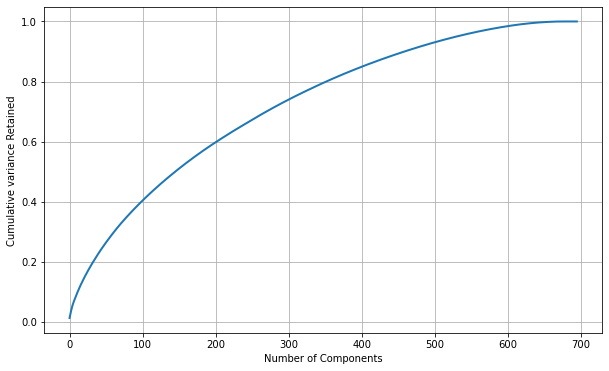

In [23]:
# Se grafica la curva del numero de componentes vs. la varianza acumulada retenida
import matplotlib.pyplot as plt
plt.figure(1, figsize=(10, 6))
plt.clf()
plt.plot(cumulative_variance_retained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('Number of Components') # Se nombra el eje x
plt.ylabel('Cumulative variance Retained') # Se nombra el eje y
plt.show()

In [24]:
# CHOOSE K
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn import datasets
import pandas as pd 

In [25]:
digits = X_train

# Standardize the feature matrix
X = StandardScaler().fit_transform(digits.data)

# Make sparse matrix
X_sparse = csr_matrix(X)

In [26]:
X_sparse.shape[1]-1

1694

In [27]:
# Create and run an TSVD with one less than number of features
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(X)

In [28]:
# List of explained variances
tsvd_var_ratios = tsvd.explained_variance_ratio_

In [29]:
# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [30]:
# Run function
select_n_components(tsvd_var_ratios, 0.95)

518

In [31]:
# Se determina el numero de componentes en base a la curva 
NComponents = 513
svd = TruncatedSVD(n_components=NComponents, n_iter=7, random_state=42) # Se establecen los parametros correspondientes
X_svd_train = svd.fit_transform(X_train) #Se define un nuevo set de entrenamiento X, transformando el anterior mediante la aplicacion del svd
X_svd_test = svd.transform(X_test) #Se define un nuevo set de prueba X, transformando el anterior mediante la aplicacion del svd

In [32]:
# Se verifica la cantidad de palabras de cada set 
print(X_svd_train.shape)
print(X_svd_test.shape)
print(y_train.shape)
print(y_test.shape)

(695, 513)
(299, 513)
(695,)
(299,)


### Modelamiento: Support Vector Machine (SVM)
Según Dubiau, se trata de un algoritmo o método supervisado de clasificación binaria en el que el entrenamiento de los datos consiste en encontrar un hiperplano óptimo que separe los vectores, los cuales representan los textos de un conjunto de datos (vectores de características), en dos grupos, considerando la mayor separación posible. Los vectores que establecen el margen de separación máxima se denominan support vectors (2013):

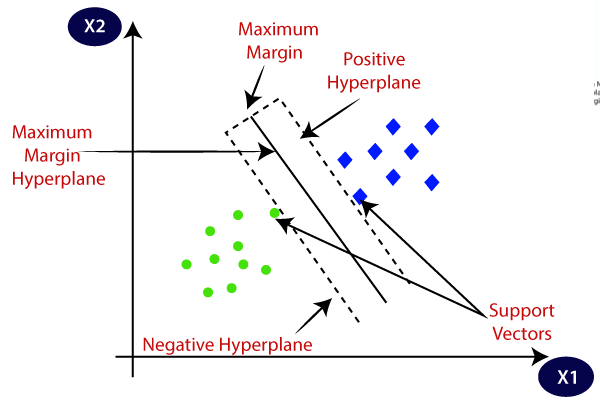

Con base en la Figura, es importante señalar que los support vectors están en el hiperplano positivo y en el hiperplano negativo. En la Figura también se pueden ver dos clases (azul y verde). De esta forma, en base a valores específicos para cada clase, se determina en qué lado del hiperplano se ubica el vector de características a clasificar (Dubiau, 2013).

In [33]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
svc=SVC(kernel='poly',C=0.1, degree=3, coef0=0.0, class_weight='balanced') # Se aplica el modelo SVM con sus hiperparametros
scores = cross_val_score(svc, X_svd_train, y_train, cv=5, scoring='accuracy') # Se valida el modelo con 10 folds
svc = SGDClassifier(max_iter=100) # Se establece el numero de iteraciones sobre el set de entrenamiento 
svc.fit(X_svd_train, y_train) # Se ajusta el modelo 

SGDClassifier(max_iter=100)

### Resultados: Evaluación
La evaluación se lleva a cabo en base a una métrica de exactitud, que representa el número de predicciones correctas sobre las predicciones totales del conjunto de prueba (Mishra, 2018). Esto quiere decir que tan exacta es la clasificación de los comentarios de los productos en relación a la polaridad del sentimiento que se expresa en cada uno.

In [34]:
# Exactitud en el set de prueba
svc.score(X_svd_test, y_test)

0.725752508361204

In [35]:
# Predecir en el set de prueba 
predicted_sentiments = svc.predict(X_svd_test)
predicted_sentiments

array(['Positive', 'Negative', 'Negative', 'Negative', 'Negative',
       'Negative', 'Positive', 'Negative', 'Positive', 'Positive',
       'Positive', 'Negative', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Negative', 'Negative',
       'Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Positive', 'Negative', 'Negative', 'Positive', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Positive', 'Positive', 'Negative', 'Negative', 'Negative',
       'Negative', 'Positive', 'Positive', 'Positive', 'Positive',
       'Positive', 'Negative', 'Negative', 'Negative', 'Positive',
       'Negative', 'Positive', 'Positive', 'Positive', 'Negative',
       'Negative', 'Negative', 'Positive', 'Negative', 'Positive',
       'Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Negative', 'Negative', 'Negative', 'Positive', 'Negative',
       'Negative', 'Negative', 'Positive', 'Positive', 'Positi

In [36]:
# Desplegar metricas para el modelo
report = metrics.classification_report(y_true=y_test, 
                                           y_pred=predicted_sentiments, 
                                           labels=['Positive', 'Negative'])
print(report)

              precision    recall  f1-score   support

    Positive       0.69      0.77      0.73       143
    Negative       0.76      0.69      0.72       156

    accuracy                           0.73       299
   macro avg       0.73      0.73      0.73       299
weighted avg       0.73      0.73      0.73       299



Está comprobado que el modelo se optimizó con un 75% de precisión. Luego, para evaluar el modelo se realiza una matriz de confusión, que básicamente permite visualizar la proporción de etiquetas predichas en relación a la proporción de etiquetas verdaderas de los comentarios extraídos de las redes sociales de los productos, luego de aplicar el algoritmo SVM. 

Confusion matrix, without normalization
[[107  49]
 [ 33 110]]
Normalized confusion matrix
[[0.68589744 0.31410256]
 [0.23076923 0.76923077]]


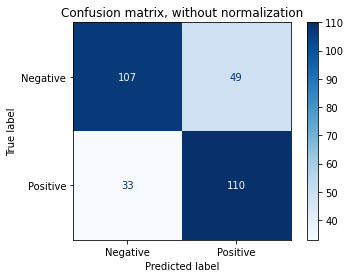

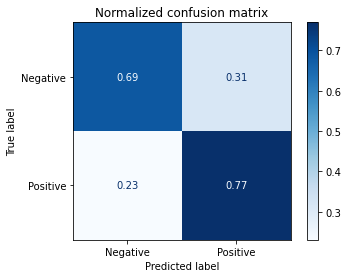

In [37]:
# Graficar matrices de confusión sin y con normalizacion 
from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix, without normalization", None), # Se nombran las matrices
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc, X_svd_test, y_test,
                                 display_labels=['Negative', 'Positive'], # Se definen las etiquetas correspondientes
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Como se puede observar en la Figura de "Normalized confusion matrix", la predicción de las etiquetas neutrales (0.88) y positivas (0.62) son más exactas que la predicción de las etiquetas negativas (0.21). 

#### Referencias:

>* Dubiau, L. (2013). Procesamiento de Lenguaje Natural en Sistemas de Análisis de Sentimientos. Universidad de Buenos Aires, 31-32.
>* Ientilucci, E. J. (2003). Using the singular value decomposition. Rochester Institute of Technology, New York, United States, 1-2.
>* Mishra, A. (2018). Metrics to Evaluate your Machine Learning Algorithm. Towards Data Science. https://towardsdatascience.com/metrics-to-evaluate-your-machine-learningalgorithm-f10ba6e38234
> * Nguyen, Heidi; Veluchamy, Aravind; Diop, Mamadou; and Iqbal, Rashed. (2018)."Comparative Study of Sentiment Analysis with Product Reviews Using MachineLearning and Lexicon-Based Approaches," SMU Data Science Review: Vol. 1 : No. 4, Article 7. Available at: https://scholar.smu.edu/datasciencereview/vol1/iss4/
>* Scikit-learn. (2020). sklearn.feature_extraction.text.CountVectorizer — scikit-learn 0.24.1 documentation. Scikit-Learn Documentation. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
>* Song, M., Yang, H., Siadat, S. H., and Pechenizkiy, M. (2013). A comparative study of dimensionality reduction techniques to enhance trace clustering performances. Expert Systems with Applications, 40(9), 3722–3737. doi:10.1016/j.eswa.2012.12.078